In [13]:
import healpy as hp
import numpy as np
from matplotlib import pyplot as plt
import h5py, os, sys
from alive_progress import alive_it
from time import sleep

In [10]:
instrument = "stage3_forecast"

cosmogrid_dir = "/global/cfs/cdirs/des/cosmogrid/"

fiducial_dir = os.path.join(cosmogrid_dir, instrument, "fiducial")
benchmark_dir = os.path.join(cosmogrid_dir, instrument, "benchmark")
grids_dir = os.path.join(cosmogrid_dir, instrument, "grid")
fil_name = "projected_probes_maps_baryonified512.h5"

In [113]:
from pathlib import Path
out_dir = '../data/20230419_24x24/'
Path(out_dir).mkdir(parents=True, exist_ok=True)

(3145728,)
12288
2.748389129453925


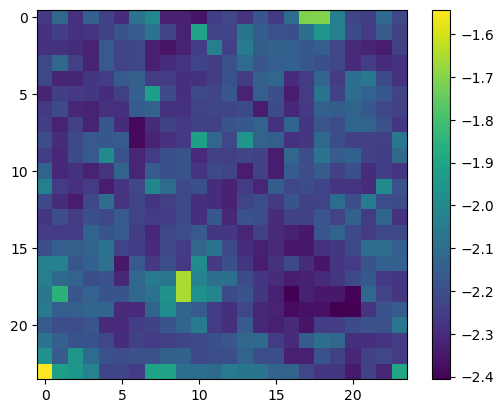

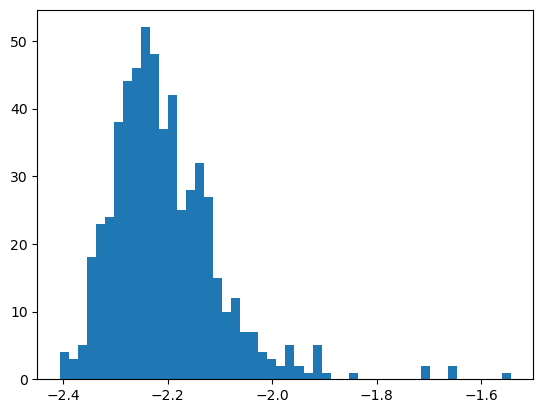

In [115]:
def IndexToDeclRa(index, nside,nest= False):
    theta,phi=hp.pixelfunc.pix2ang(nside ,index,nest=nest)
    return -np.degrees(theta-np.pi/2.),np.degrees(phi)

nside = 512
nside_small = 32
with h5py.File(os.path.join("/global/cfs/cdirs/des/cosmogrid/stage3_forecast/fiducial/cosmo_fiducial/", perm, fil_name)) as fil:
    map_test_ = np.array(fil['kg']["stage3_lensing1"])
    print(map_test_.shape)

# use the center of the pixels at lower resolution as projection centers
map_indexes = np.arange(hp.nside2npix(nside_small))
dec_,ra_ = IndexToDeclRa(map_indexes, nside_small,nest= False)
pairs_ = np.vstack([ra_,dec_])
      
# initial guess for the size of the patch
# delta = np.sqrt(hp.nside2pixarea(nside_small, degrees = True))*2
# pixels = int(delta/(hp.nside2resol(nside, arcmin=True)/60))
res = hp.nside2resol(nside, arcmin=True)
# xsize=2**int(np.log2(pixels))  
xsize=24  
print(pairs_.shape[1])

print(24 * res / 60)

for i in range(pairs_.shape[1]):
    if i<1:
        ra_,dec_ = pairs_[:,i]
        m_projected = hp.gnomview(map_test_, rot=(ra_,dec_), xsize=xsize ,no_plot=True,reso=res,return_projected_map=True)
        plt.imshow(np.log10(m_projected))
        plt.colorbar()
        plt.show()
        plt.hist(np.ravel(np.log10(m_projected)), bins=50)
        plt.show()
    break

In [139]:
def gen_from_one_file(fil_name, nside=512, nside_crop=32, \
                      keys=["stage3_lensing" + str(i) for i in range(1, 5)], out_shape=(24, 24, 4)):
    kappas = {}
    with h5py.File(fil_name) as fil:
        for key in fil['kg'].keys():
            kappas[key] = np.array(fil['kg'][key])
    
    map_indexes = np.arange(hp.nside2npix(nside_crop))
    dec_,ra_ = IndexToDeclRa(map_indexes,nside_crop,nest=False)
    pairs_ = np.vstack([ra_,dec_])
    res = hp.nside2resol(nside, arcmin=True)
    xsize=out_shape[0]
    
    out_arr = np.empty((pairs_.shape[1], *out_shape))
    
    for chan, key in enumerate(keys):
        kappa = np.array(kappas[key])

        for i in range(pairs_.shape[1])[:10]:
            m_projected = hp.gnomview(kappa, rot=pairs_[:,i], xsize=xsize,\
                                      no_plot=True,reso=res,return_projected_map=True)
            out_arr[i, :, :, chan] = m_projected
    return out_arr

In [140]:
%time out_arr = gen_from_one_file(os.path.join("/global/cfs/cdirs/des/cosmogrid/stage3_forecast/fiducial/cosmo_fiducial/", perm, fil_name))

CPU times: user 4.75 s, sys: 2.91 s, total: 7.66 s
Wall time: 4.11 s


In [ ]:
for grid in alive_it(os.listdir(grids_dir)[:5], force_tty=True, bar="checks", spinner="notes")):
    path_grid = os.path.join(grids_dir, grid)
    for perm in os.listdir(path_grid):
        if "perm" not in perm:
            continue
        out_arr = gen_from_one_file(os.path.join(path_grid, perm, fil_name))
        np.save(os.path.join(out_dir, grid), out_arr)
    break

|                                        | ▄▆█ 0/5 [0%] in 12s (~0s, 0.0/s) 

In [112]:
out_dir

'../data/20230419_24x24/'